In this notebook we consider the K2 target

- We correct for K2 motion
- We run the corrected light curve and mesured periods through the pymc3 framework to try and model the transits

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
import lightkurve as lk
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table
from lightkurve import search_lightcurvefile
from lightkurve import search_lightcurve
from lightkurve import search_targetpixelfile
import exoplanet as xo

In [2]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 18
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True
plt.rcParams['axes.linewidth']=1.5

# Kepler Data

https://exoplanetarchive.ipac.caltech.edu/overview/EPIC%20246711015

In [3]:
star = lk.search_lightcurve('EPIC 246711015',author='EVEREST')
#lk

In [4]:
k2 = star.download_all()

In [5]:
k2

LightCurveCollection of 1 objects:
    0: <KeplerLightCurve LABEL="EPIC 246711015" CAMPAIGN=13 AUTHOR=EVEREST FLUX_ORIGIN=flux>

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

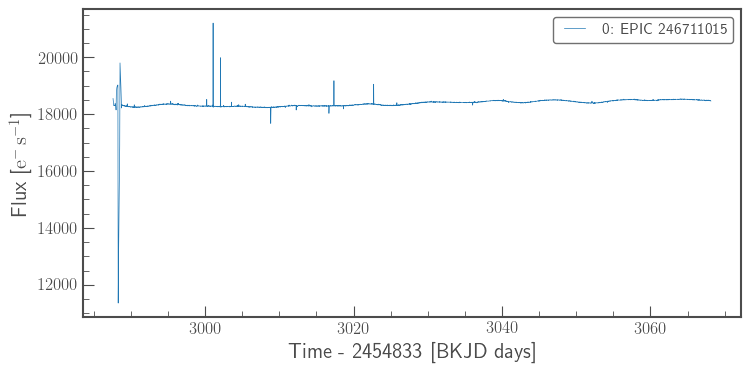

In [6]:
k2.plot()

Downloading the TPF

Following this tutorial:http://docs.lightkurve.org/tutorials/3-science-examples/periodograms-optimizing-the-snr.html

To get rid of some of the K2 motion that is in the data

In [8]:
TARGET = "EPIC 246711015"
tpf = lk.search_targetpixelfile(TARGET, author="K2", cadence='short').download()

In [9]:
tpf

KeplerTargetPixelFile Object (ID: 246711015)

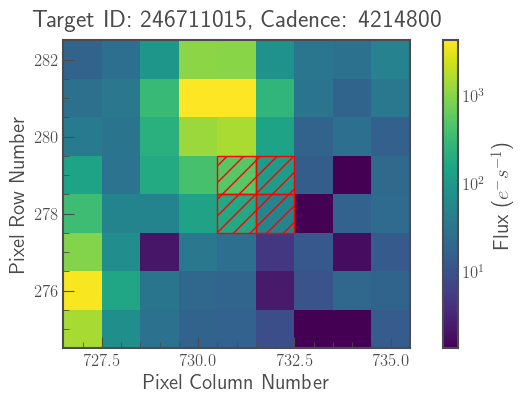

In [10]:
tpf.plot(scale='log', aperture_mask=tpf.pipeline_mask);

In [11]:
lc = tpf.to_lightcurve()
lc = lc.normalize(unit='ppm').remove_nans().remove_outliers().fill_gaps()

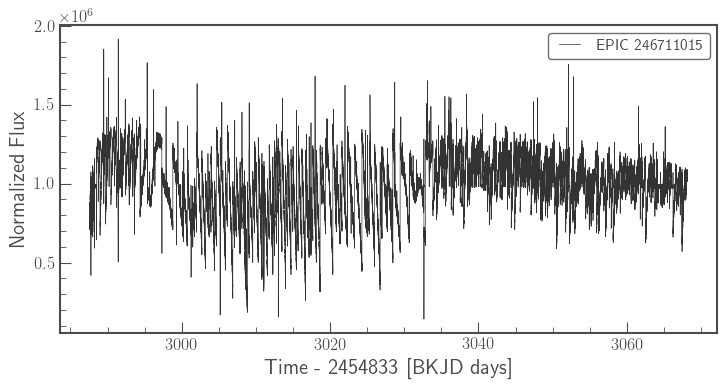

In [12]:
lc.plot();

In [13]:
import astropy.units as u
pg = lc.to_periodogram(freq_unit=u.microHertz, maximum_frequency=400, minimum_frequency=10)

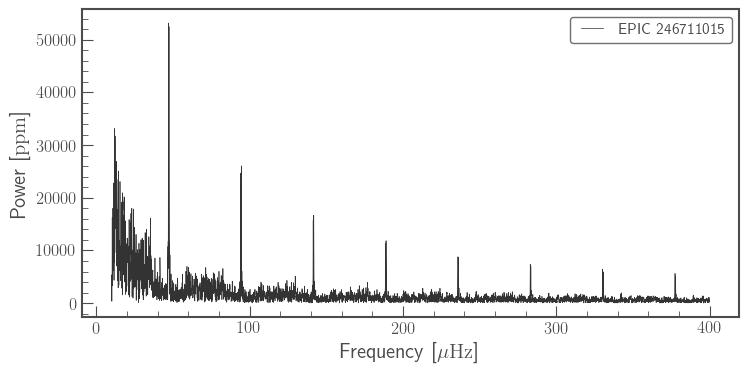

In [14]:
ax = pg.plot();

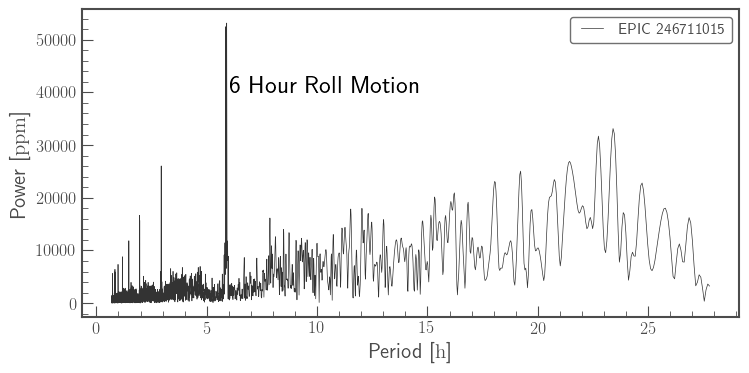

In [15]:
ax = pg.plot(view='Period', unit=u.hour)
ax.text(6, 40000, '6 Hour Roll Motion');

In [16]:
lc = tpf.to_lightcurve().normalize().remove_nans().remove_outliers()
clc = lc.to_corrector("sff").correct(windows=10).remove_outliers().fill_gaps()

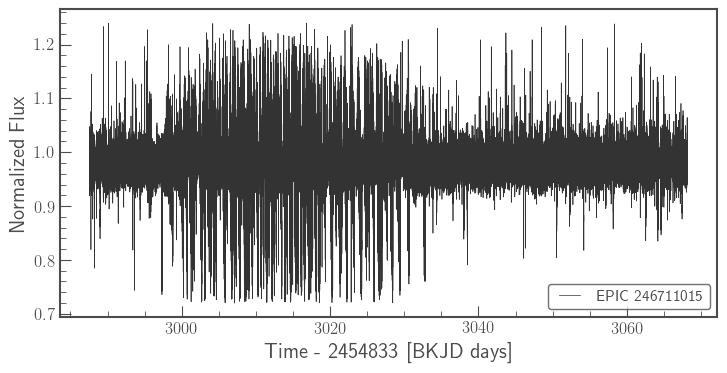

In [17]:
clc.plot();

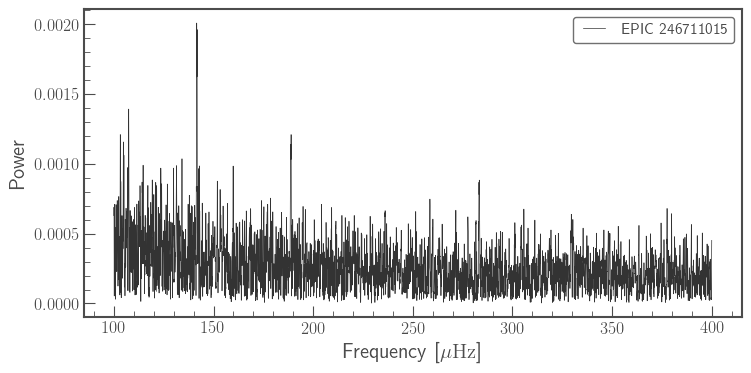

In [18]:
pg_clean = clc.to_periodogram(freq_unit=u.microHertz, maximum_frequency=400, minimum_frequency=100)
ax = pg_clean.plot()

100%|██████████| 3/3 [00:19<00:00,  6.46s/it]


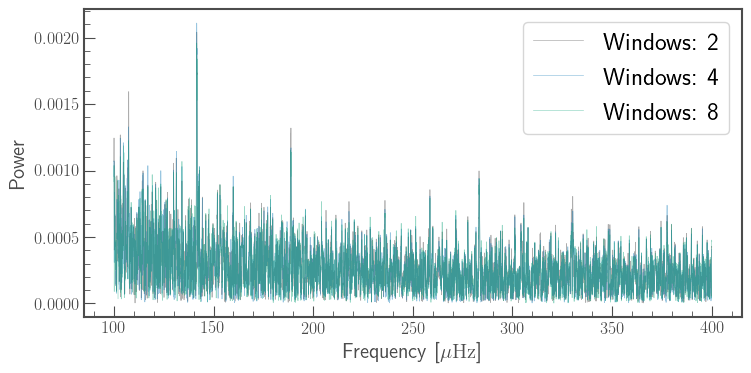

In [19]:
# Loop over several windows
from tqdm import tqdm
for windows in tqdm([2, 4, 8]):
    # Create the light curve
    lc =  tpf.to_lightcurve().normalize().remove_nans().remove_outliers()
    clc = lc.to_corrector('sff').correct(windows=windows).remove_outliers().fill_gaps()
    # Create the periodogram
    p_clean = clc.to_periodogram(freq_unit=u.microHertz, maximum_frequency=400, minimum_frequency=100)
    # Plot the periodogram
    if windows == 2:
        ax = p_clean.plot(alpha=0.4, label='Windows: {}'.format(windows))
    else:
        p_clean.plot(ax=ax, alpha=0.4, label='Windows: {}'.format(windows))
ax.legend();

We can also vary the aperture size

In [20]:
aperture_small = tpf.create_threshold_mask(threshold=50)
aperture_large = tpf.create_threshold_mask(threshold=2)

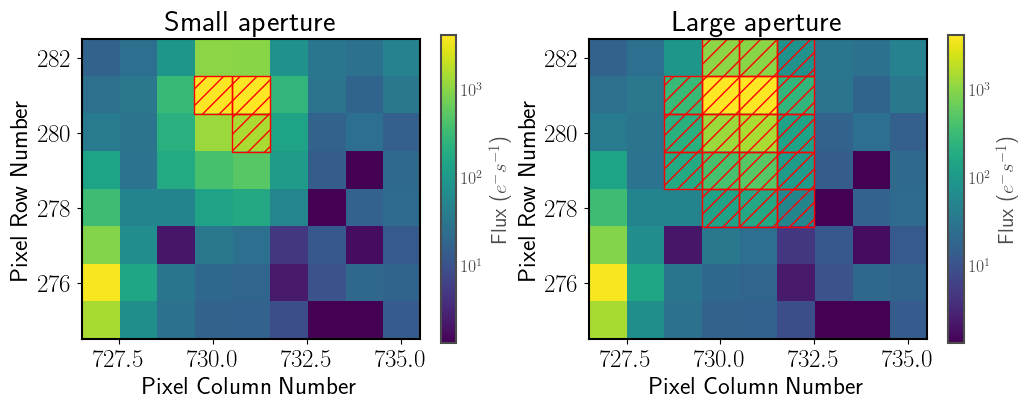

In [21]:
# Two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot pipeline aperture mask
tpf.plot(axs[0], scale='log', aperture_mask=aperture_small)
axs[0].set_title('Small aperture')

# Plot larger aperture mask
tpf.plot(axs[1], scale='log', aperture_mask=aperture_large)
axs[1].set_title('Large aperture');

In [22]:
# Create the light curve with the pipelien aperture.
lc_small = tpf.to_lightcurve(aperture_mask=aperture_small).normalize().remove_nans().remove_outliers()
lc_small = lc_small.to_corrector('sff').correct().remove_outliers().fill_gaps()

# Create a light curve with a slightly larger aperture
lc_large = tpf.to_lightcurve(aperture_mask=aperture_large).normalize().remove_nans().remove_outliers()
lc_large = lc_large.to_corrector('sff').correct().remove_outliers().fill_gaps()

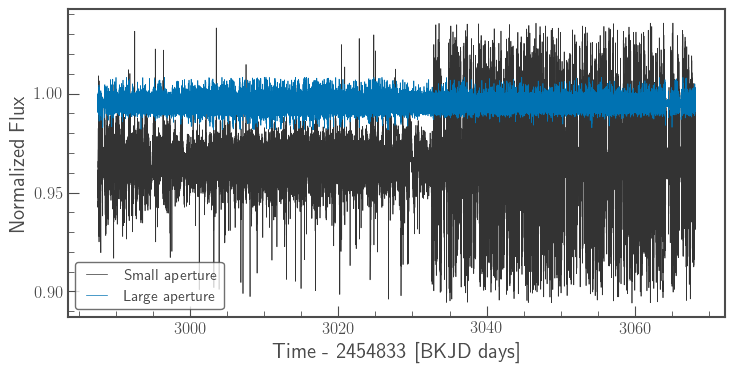

In [23]:
#Plot the pipeline and large aperture light curves
ax = lc_small.plot(label='Small aperture')
lc_large.plot(ax=ax, label='Large aperture');

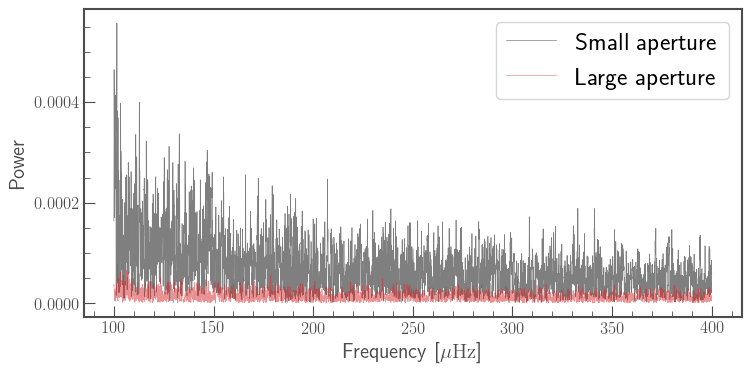

In [24]:
# Create the periodograms
pg_small = lc_small.to_periodogram(freq_unit=u.microHertz, maximum_frequency=400, minimum_frequency=100)
pg_large = lc_large.to_periodogram(freq_unit=u.microHertz, maximum_frequency=400, minimum_frequency=100)


# Plot the periodograms
ax = pg_small.plot(c='k', alpha=0.5, label='Small aperture')
pg_large.plot(ax=ax, c='C3', alpha=0.5, label='Large aperture')

ax.legend();

In [25]:
clc.time.bkjd

array([2987.57169037, 2987.57237153, 2987.57305259, ..., 3068.15263549,
       3068.15331653, 3068.15399757])

In [26]:
clc.flux.value

array([0.97759532, 0.97954625, 0.92005031, ..., 1.0026344 , 0.95906318,
       1.06241256])

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

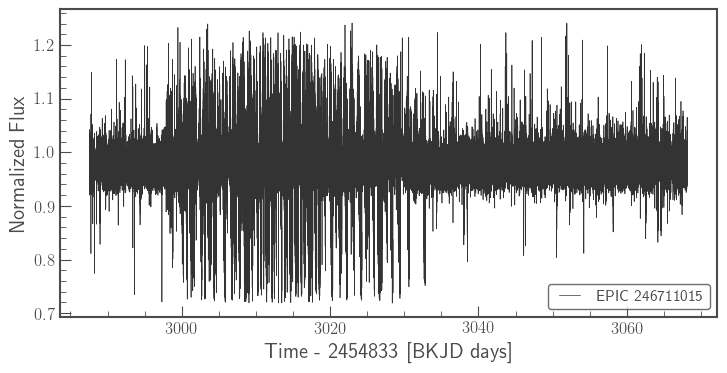

In [74]:
clc.plot()

In [48]:
print(p_clean.period_at_max_power)
print(p_clean.frequency_at_max_power.value)
print(p_clean.max_power)
print(p_clean.power)

0.007065243932606177 1 / uHz
141.53792983494728
0.0019594494074598938
[0.00091594 0.00103792 0.00103792 ... 0.00047346 0.00047657 0.00046472]


In [55]:
period1 = 13.284219
period2 = 24.213117

(-2.0, 2.0)

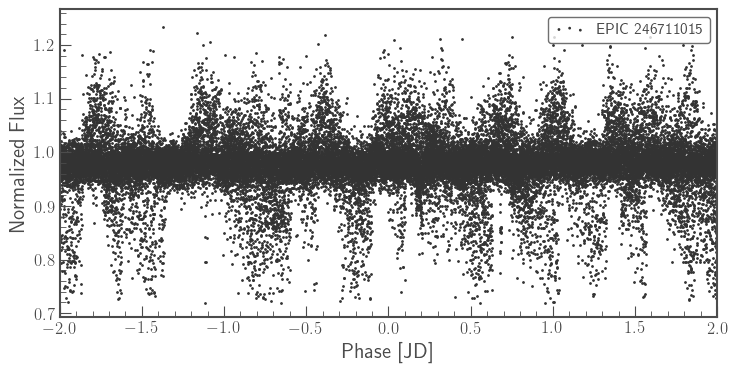

In [63]:
ax = clc.fold(period=period1).scatter(),#epoch_time=p_clean.frequency_at_max_power.value).scatter()
plt.xlim(-2,2)
#ax = tess_lc_flat.fold(period=planet_periodt, epoch_time=planet_t0t).scatter()

(-2.0, 2.0)

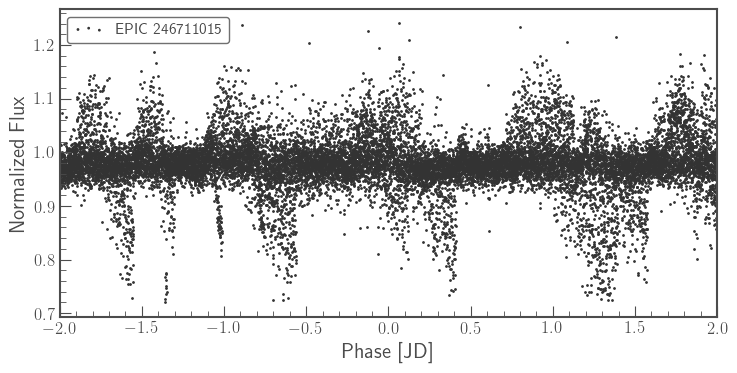

In [62]:
clc.fold(period=period2,epoch_time=p_clean.frequency_at_max_power.value).scatter()
plt.xlim(-2,2)

### We can use the periods measured that are on exofop as a starting point and then throw the corrected light curve into the pymc3 framework to model the transits


https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=k2pandc

In [27]:
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx

In [28]:
from celerite2.theano import terms, GaussianProcess
import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt

import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess

planet 1 period = 13.284219 +0.002846 -0.001880
planet 2 period = 24.213117 +0.003408 -0.003407

tutorial: https://gallery.exoplanet.codes/tutorials/transit/#the-transit-model-in-pymc3

with stellar variability: https://gallery.exoplanet.codes/tutorials/lc-gp-transit/

In [29]:
periods = [13.284219 , 24.213117]
t0s = periods * np.random.rand(2)
t = clc.time.bkjd
y= clc.flux.value
yerr = clc.flux_err.value

In [30]:
t0s

array([ 0.48345012, 19.0490104 ])

In [32]:
phase_lc = np.linspace(-1, 1, 100)

In [68]:
with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)

    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=2)

    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
    period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

    r = pm.Uniform(
        "r", lower=0.01, upper=0.1, shape=2, testval=np.array([0.04, 0.06])
    )
    b = xo.distributions.ImpactParameter(
        "b", ror=r, shape=2, testval=np.random.rand(2)
    )

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u[0], u[1]).get_light_curve(
        orbit=orbit, r=r, t=t
    )
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)


    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [b, r, u, logP, t0, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 353265.4539419585 -> 353273.63935630483


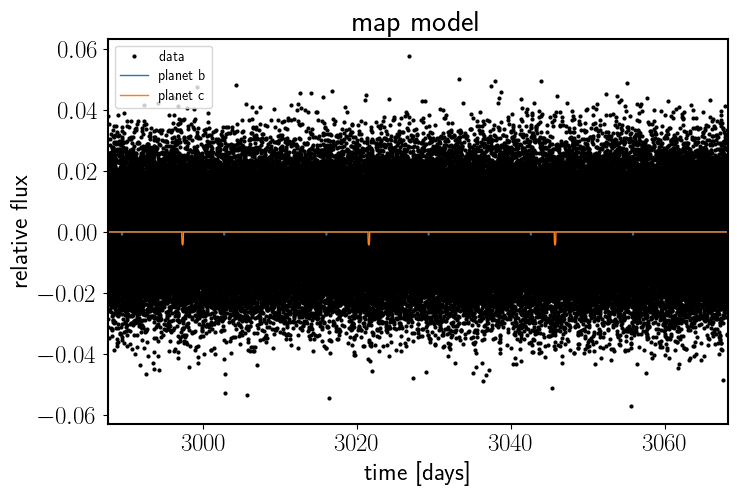

In [69]:
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(
        t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l)
    )
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

You can now sample from the posterior of this model we just ran

In [70]:
np.random.seed(42)
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        cores=2,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, r, u, logP, t0, mean]


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30537 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [71]:
import arviz as az

az.summary(trace, var_names=["period", "t0", "r", "b", "u", "mean"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
period[0],13.271,0.028,13.218,13.312,0.011,0.008,8.0,11.0,1.25
period[1],24.204,0.006,24.194,24.217,0.002,0.001,13.0,71.0,1.13
t0[0],0.439,0.810,-1.146,1.942,0.151,0.135,34.0,23.0,1.06
t0[1],20.184,0.781,18.564,21.347,0.223,0.161,14.0,70.0,1.13
r[0],0.032,0.018,0.011,0.073,0.006,0.005,22.0,43.0,1.23
r[1],0.060,0.004,0.053,0.066,0.000,0.000,58.0,91.0,1.01
b[0],0.583,0.315,0.123,1.078,0.119,0.106,8.0,40.0,1.23
b[1],0.231,0.149,0.024,0.531,0.036,0.026,19.0,58.0,1.09
u[0],0.466,0.314,0.006,1.051,0.045,0.032,49.0,122.0,1.03
u[1],0.066,0.312,-0.491,0.693,0.052,0.037,36.0,123.0,1.04


In [72]:
import corner

truth = dict(
    zip(
        ["period", "r"],
        pmx.eval_in_model([period, r], model.test_point, model=model),
    )
)
_ = corner.corner(
    trace,
    var_names=["period", "r"],
    truths=truth,
)

TypeError: cannot perform reduce with flexible type

Phase Plots

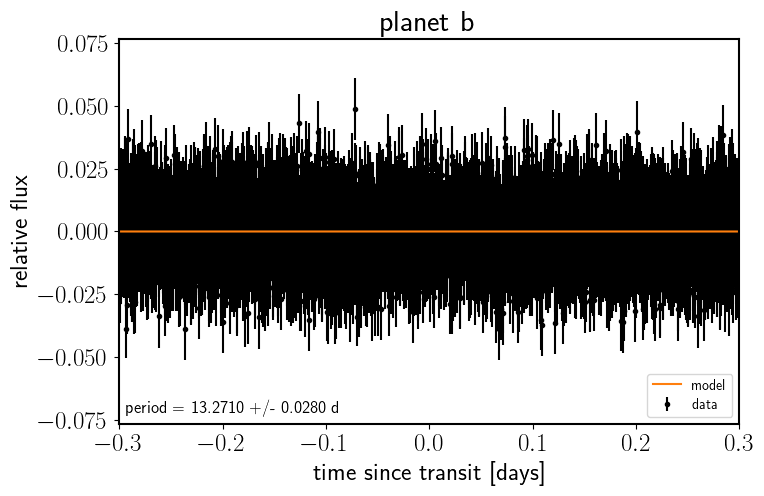

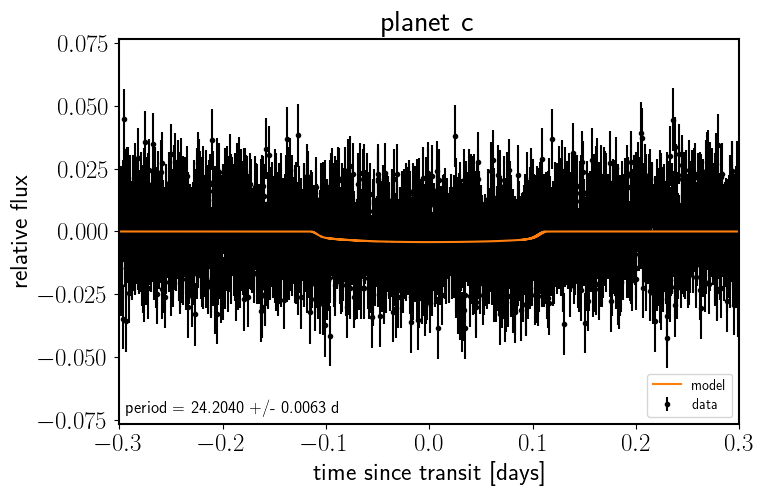

In [73]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    period_trace = trace.posterior["period"].values[:, :, n]
    p = np.median(period_trace)
    t0 = np.median(trace.posterior["t0"].values[:, :, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    lcs = trace.posterior["light_curves"].values
    other = np.median(lcs[:, :, :, (n + 1) % 2], axis=(0, 1))

    # Plot the folded data
    x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(
        x_fold, y - other, yerr=yerr, fmt=".k", label="data", zorder=-1000
    )

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = lcs[:, :, inds, n] + trace.posterior["mean"].values[:, :, None]
    pred = np.median(pred, axis=(0, 1))
    plt.plot(x_fold[inds], pred, color="C1", label="model")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(period_trace), np.std(period_trace)
    )
    plt.annotate(
        txt,
        (0, 0),
        xycoords="axes fraction",
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=12,
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)